# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from wordcloud import WordCloud
import geopandas
pd.options.display.max_columns = 100
plt.style.use(['default'])

# Constants

In [2]:
themes = [
    'Authorities & Politics', 'Cases and deaths', 'Economic impact', 'Educational impact', 'People stories',
       'Preventive measures', 'Vaccines and vaccination', 'Virus spreading'
]

subthemes = [
    'subtheme11', 'subtheme12', 'subtheme21', 'subtheme22', 'subtheme41', 'subtheme42', 'subtheme43', 
    'subtheme44', 'subtheme51', 'subtheme52', 'subtheme53', 'subtheme61', 'subtheme62', 'subtheme63', 
    'subtheme64', 'subtheme65', 'subtheme66', 'subtheme71', 'subtheme72', 'subtheme73', 'subtheme74'
]

emotions = [
    'anger', 'sadness', 'optimism', 'joy'
]

keywords = [
    'remote working', 'homeschooling', 'panic buying', 'sars-cov-2', 'wearing masks', 'ncov', 'wuhan', 
    'social distancing', 'vaccination', 'quarantine', 'outbreak', 'vaccine', 'lockdown', 'pandemic', 
    'coronavirus', 'covid'
]
keywords2 = [w.replace(' ', '_').replace('-', '_') for w in keywords]

# Functions

In [3]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.fm' % (x * 1e-3)

# Load and process lookup tables

In [4]:
# Load lookup tables
media_list = pd.read_csv('./../data/external/MediaList.csv', sep=";")
theme_desc = pd.read_csv('./../data/external/theme_desc.csv')
subtheme_desc = pd.read_csv('./../data/external/subtheme_desc.csv')
topics = pd.read_parquet('./news_tweets_topics.parquet')
news_accounts = pd.read_parquet('./../data/raw/news_accounts.parquet')
users = pd.read_parquet('./../data/raw/users.parquet')

# Process lookup tables
topics['tweetId'] = topics.tweetId.astype('float64')
news_accounts = news_accounts.merge(media_list)
news_accounts['userId'] = news_accounts.userId.astype('float64')

# Load and process News Tweets

In [6]:
# Load news tweets
news_tweets = pd.read_parquet('./../data/raw/news_tweets_with_em_scores.parquet')

# Define prevalent emotion and emotion score
news_tweets['emotion_score'] = news_tweets[['anger','joy','optimism','sadness']].max(axis=1)
news_tweets['prevalent_emotion'] = news_tweets[['anger','joy','optimism','sadness']].idxmax(axis=1)
news_tweets['prevalent_emotion'] = np.where(news_tweets.emotion_score>0.5, news_tweets.prevalent_emotion, 'undefined')

# Include country information and filter valid news accountsw
news_tweets = news_tweets.merge(news_accounts[['userId','country']])
news_tweets = news_tweets[~news_tweets[emotions].isnull().any(axis=1)]
news_tweets = news_tweets.sort_values('date').drop_duplicates('conversationId', keep='first')
news_tweets = news_tweets[news_tweets.lang=='en']
print('Number of valid news tweets:', news_tweets.shape[0])

# Include theme and subtheme
news_tweets = news_tweets[~news_tweets.conversationId.isnull()].merge(topics[['theme'] + subthemes + ['tweetId']], how='left', on='tweetId')
news_tweets['subtheme'] = news_tweets[subthemes].idxmax(axis=1)
news_tweets['subtheme'] = news_tweets.subtheme.apply(lambda x: int(x[-2:]))
news_tweets['aux'] = news_tweets[subthemes].sum(axis=1)
news_tweets.loc[news_tweets.aux==0,'subtheme'] = news_tweets.loc[news_tweets.aux==0,'theme']*10
news_tweets = news_tweets.drop(subthemes + ['aux'], axis=1)

# Include date and week features
news_tweets['ds'] = news_tweets.date.dt.date
news_tweets['dsw'] = (news_tweets['date'] + pd.offsets.Week(weekday=6)).dt.date

Number of valid news tweets: 1678217


# Load and process Comments

In [7]:
# Load valid comments
plain_comments = pd.read_parquet('./../data/raw/comments.parquet')
comments = pd.read_parquet('./../data/raw/user_tweets_with_em_scores.parquet')
comments = comments[comments.tweetId.isin(plain_comments.tweetId)]; del plain_comments
comments = comments[comments.conversationId.isin(news_tweets.conversationId)]
comments = comments[~comments[emotions].isnull().any(axis=1)]
comments = comments[comments.lang=='en']
print('Number of valid comments:', comments.shape[0])

# Include news tweet data
comments = comments.merge(news_tweets.rename(columns={
    'date':'news_date', 'userId':'news_id', 'prevalent_emotion':'news_prevalent_emotion', 'emotion_score':'news_emotion_score',
    'anger':'news_anger', 'sadness':'news_sadness', 'optimism':'news_optimism', 'joy':'news_joy'
})[[
    'conversationId', 'news_date', 'news_id', 'news_prevalent_emotion', 'news_emotion_score', 
    'news_anger', 'news_sadness', 'news_optimism', 'news_joy', 'theme', 'subtheme', 'country'
]], how='left')

# Define prevalent emotion and emotion score
comments['emotion_score'] = comments[['anger','joy','optimism','sadness']].max(axis=1)
comments['prevalent_emotion'] = comments[['anger','joy','optimism','sadness']].idxmax(axis=1)
comments['prevalent_emotion'] = np.where(comments.emotion_score>0.5, comments.prevalent_emotion, 'undefined')

# Define continent information
comments = comments.merge(pd.DataFrame({
    'country':['AU', 'UK', 'US', 'CA', 'NZ', 'ZA', 'KE', 'NG', 'IN', 'PH', 'MY','IE'],
    'continent':['Oceania', 'Europe', 'America', 'America', 'Oceania', 'Africa', 'Africa', 'Africa', 'Asia', 'Asia', 'Asia', 'Europe']
}))

# Include date, week and month features
comments['ds'] = comments.news_date.dt.date
comments['dsw'] = (comments['news_date'] + pd.offsets.Week(weekday=6)).dt.date
comments['dsm'] = pd.to_datetime(comments.news_date.dt.year.astype(str) + '-' + comments.news_date.dt.month.astype(str) + '-1')

Number of valid comments: 17620904


# Paper Figures

### Fig 1

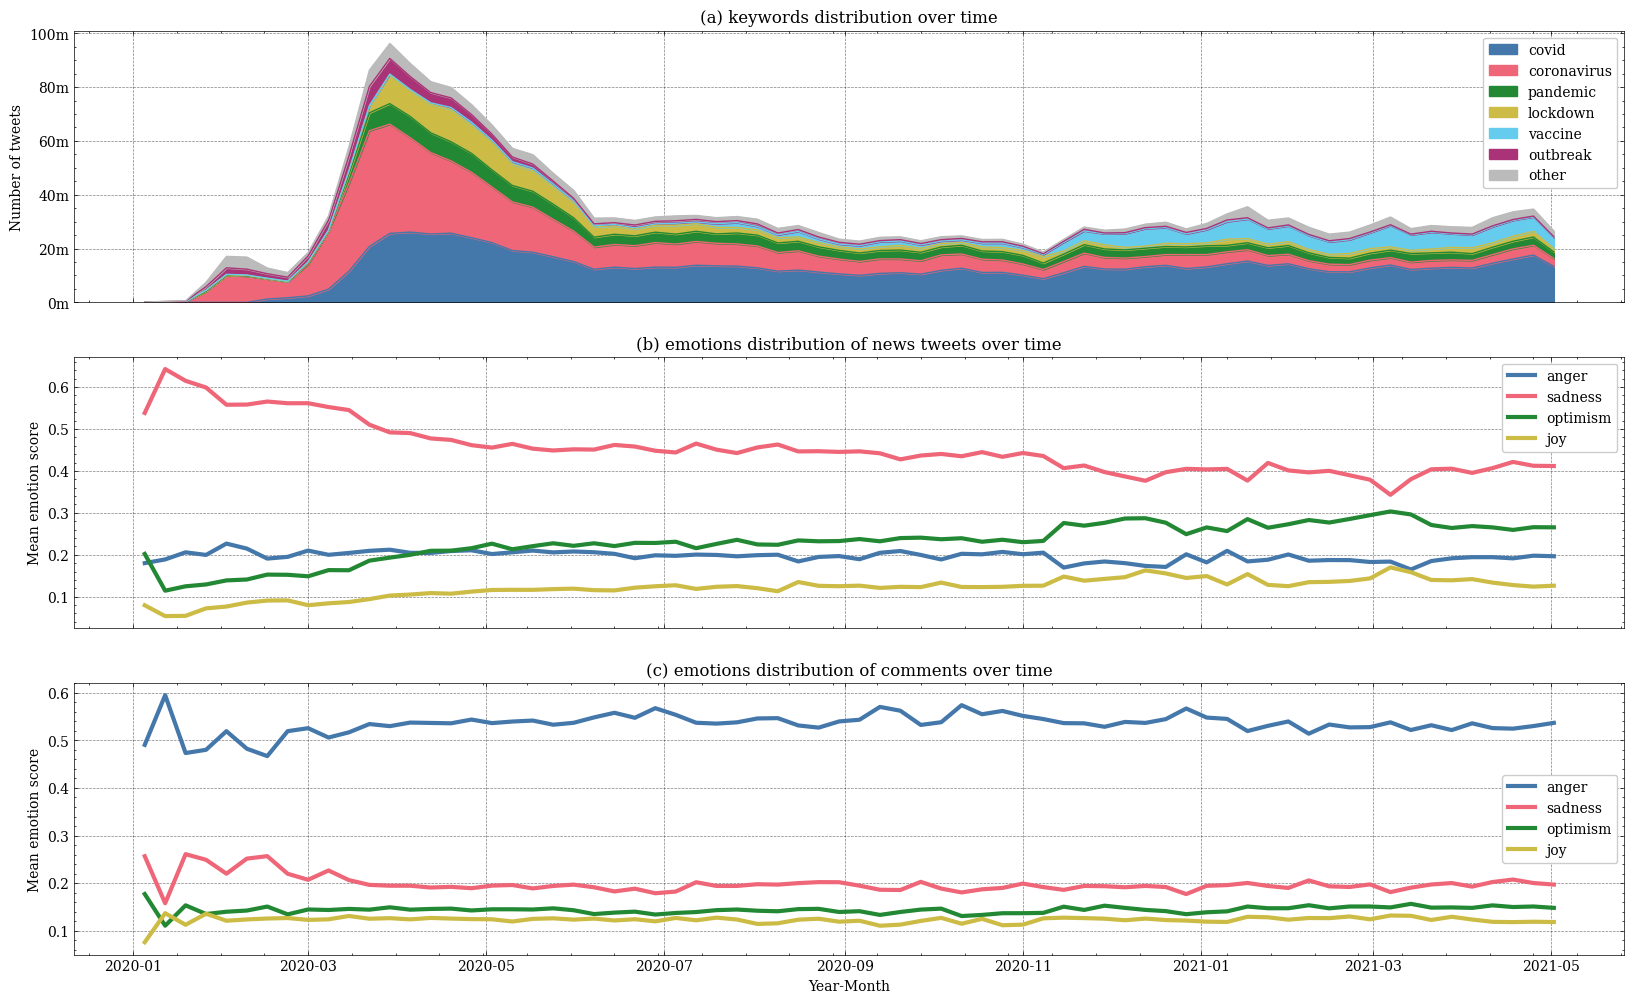

In [8]:
# Define less frequent keywords
less_freq_kw = ['vaccination', 'quarantine', 'remote_working', 'homeschooling', 'panic_buying', 'sars_cov_2', 'wearing_masks', 'ncov', 'wuhan', 'social_distancing']

# Define subplots dataframes
fig1_kw = news_tweets.copy()
for i, w in enumerate(keywords):
    fig1_kw[keywords2[i]] = fig1_kw.content.apply(lambda x: w in x.lower())
fig1_kw[keywords2].sum().sort_values().index
fig1_kw = fig1_kw.groupby('dsw')[keywords2].sum()
fig1_kw['other'] = fig1_kw[less_freq_kw].sum(axis=1)
fig1_kw = fig1_kw[[
    'covid', 'coronavirus', 'pandemic', 'lockdown', 'vaccine', 'outbreak', 'other'
]]
fig1_nt = news_tweets.groupby('dsw')[emotions].mean()
fig1_cm = comments.groupby('dsw')[['anger', 'sadness', 'optimism', 'joy']].mean()

# Plot figure
with plt.style.context(['science', 'bright', 'no-latex', 'grid']):
    formatter = FuncFormatter(thousands)
    fig, axs = plt.subplots(3,1,figsize=(20, 12), sharex=True)
    fig1_kw.plot.area(ax=axs[0], title="(a) keywords distribution over time", ylabel="Number of tweets"); axs[0].yaxis.set_major_formatter(formatter)
    fig1_nt.plot.line(ax=axs[1], title="(b) emotions distribution of news tweets over time", ylabel="Mean emotion score", linewidth=3)
    fig1_cm.plot.line(ax=axs[2], title="(c) emotions distribution of comments over time", ylabel="Mean emotion score", xlabel="Year-Month", linewidth=3)

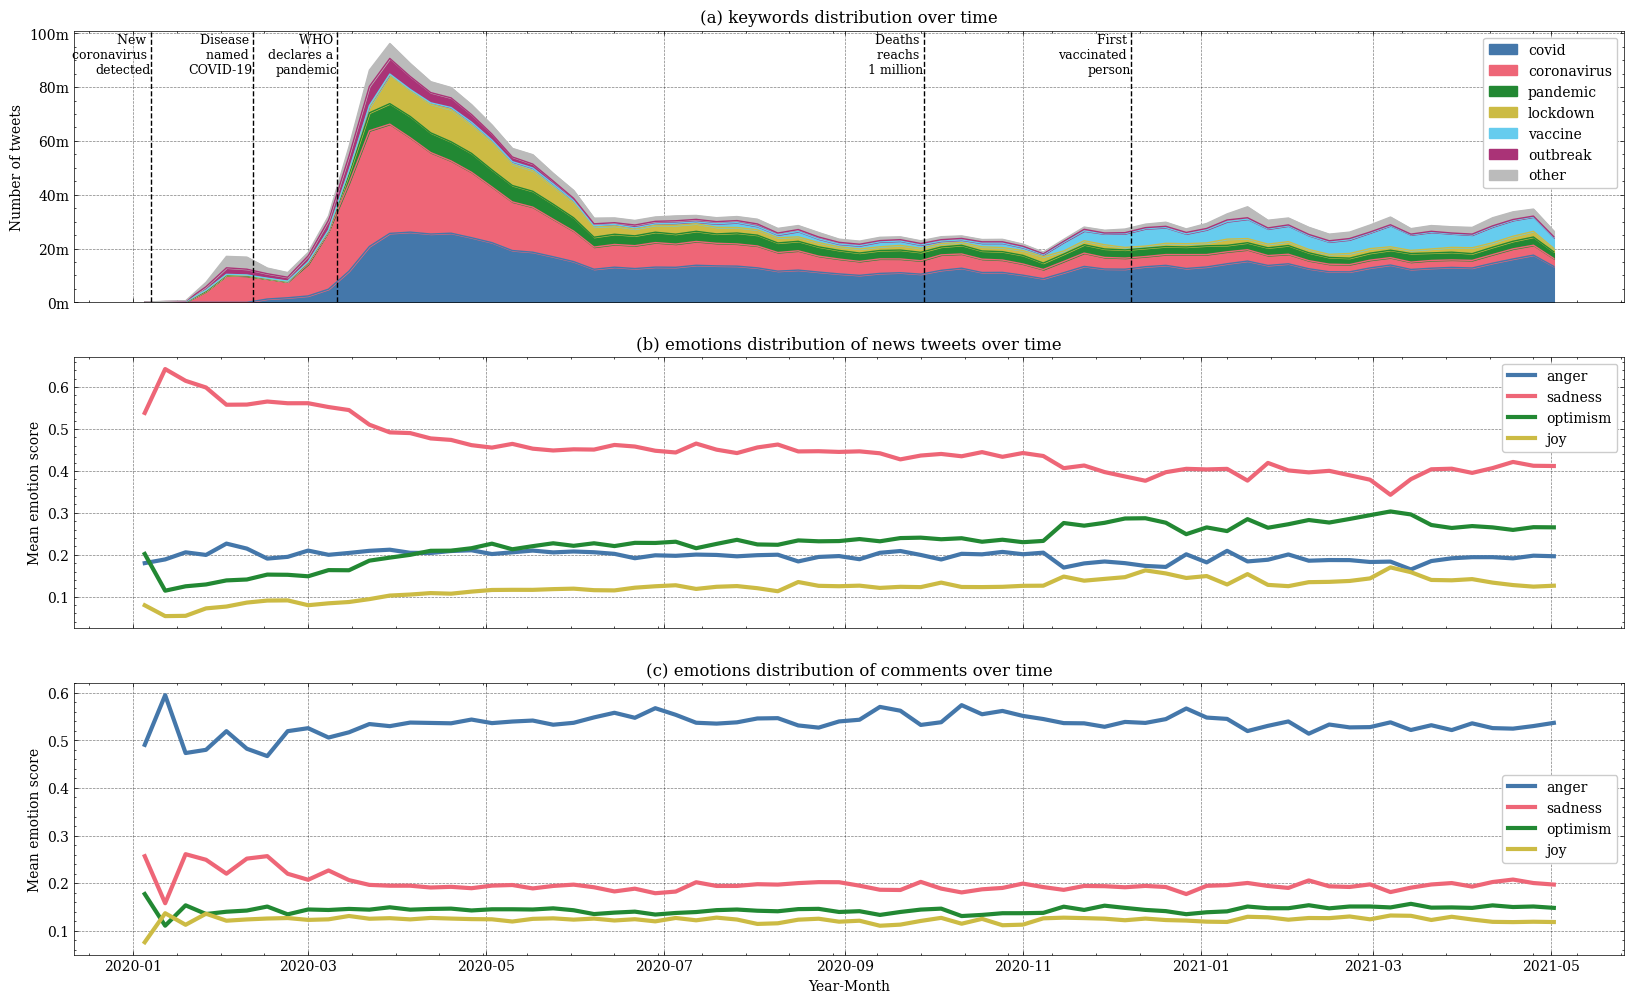

In [9]:
# Plot figure
with plt.style.context(['science', 'bright', 'no-latex', 'grid']):
    formatter = FuncFormatter(thousands)
    fig, axs = plt.subplots(3,1,figsize=(20, 12), sharex=True)
    fig1_kw.plot.area(ax=axs[0], title="(a) keywords distribution over time", ylabel="Number of tweets"); axs[0].yaxis.set_major_formatter(formatter)
    
    # Add labels to the plot
    style = dict(size=9, color='black')
    
    axs[0].axvline(pd.Timestamp('2020-01-07'),color='k',linestyle='--')
    axs[0].text('2020-01-07', 100000, "New \ncoronavirus \ndetected", ha='right', va='top', **style)

    axs[0].axvline(pd.Timestamp('2020-02-11'),color='k',linestyle='--')
    axs[0].text('2020-2-11', 100000, "Disease \nnamed \nCOVID-19", ha='right', va='top', **style)
    
    axs[0].axvline(pd.Timestamp('2020-03-11'),color='k',linestyle='--')
    axs[0].text('2020-3-11', 100000, "WHO \ndeclares a \npandemic", ha='right', va='top', **style)
    
    axs[0].axvline(pd.Timestamp('2020-09-28'),color='k',linestyle='--')
    axs[0].text('2020-09-28', 100000, "Deaths \nreachs \n1 million", ha='right', va='top', **style)
    
    axs[0].axvline(pd.Timestamp('2020-12-08'),color='k',linestyle='--')
    axs[0].text('2020-12-08', 100000, "First \nvaccinated \nperson", ha='right', va='top', **style)
    

#     ax.text('2012-7-4', 4250, "Independence Day", ha='center', **style)
#     ax.text('2012-9-4', 4850, "Labor Day", ha='center', **style)
#     ax.text('2012-10-31', 4600, "Halloween", ha='right', **style)
#     ax.text('2012-11-25', 4450, "Thanksgiving", ha='center', **style)
#     ax.text('2012-12-25', 3850, "Christmas ", ha='right', **style)
    
    fig1_nt.plot.line(ax=axs[1], title="(b) emotions distribution of news tweets over time", ylabel="Mean emotion score", linewidth=3)
    fig1_cm.plot.line(ax=axs[2], title="(c) emotions distribution of comments over time", ylabel="Mean emotion score", xlabel="Year-Month", linewidth=3)

### Fig 2

In [30]:
cd = {
    'AU':'Australia', 'UK':'United Kingdom', 'IN':'India', 'NZ':'New Zeland', 
    'NG':'Nigeria', 'IE':'Ireland', 'CA':'Canada', 'KE':'Kenya', 
    'ZA':'South Africa', 'PH':'Philippines', 'US':'United States', 'MY':'Malaysia'
}

In [10]:
fig2_th = news_tweets.merge(theme_desc).groupby(['country', 'theme_desc']).tweetId.nunique().rename('tweet_count').reset_index()
fig2_th = fig2_th.pivot_table('tweet_count', ['country'], 'theme_desc')
fig2_th['sum'] = fig2_th.sum(axis=1)
fig2_th.iloc[:, :-1] = fig2_th.iloc[:, :-1].div(fig2_th['sum'], axis=0)
fig2_th = fig2_th.drop('sum', axis=1).reset_index()
fig2_th = fig2_th[['country'] + list(fig2_th[themes].sum().sort_values(ascending=False).index)]
fig2_th = fig2_th.sort_values('Economic impact', ascending=True)

fig2_em = comments.groupby(['country', 'prevalent_emotion']).tweetId.nunique().rename('tweet_count').reset_index()
fig2_em = fig2_em.pivot_table('tweet_count', ['country'], 'prevalent_emotion')
fig2_em['sum'] = fig2_em.sum(axis=1)
fig2_em.iloc[:, :-1] = fig2_em.iloc[:, :-1].div(fig2_em['sum'], axis=0)
fig2_em = fig2_em.drop('sum', axis=1).reset_index()
fig2_em = fig2_em[['country'] + list(fig2_em[emotions + ['undefined']].sum().index)]
fig2_em = fig2_em.sort_values('anger')

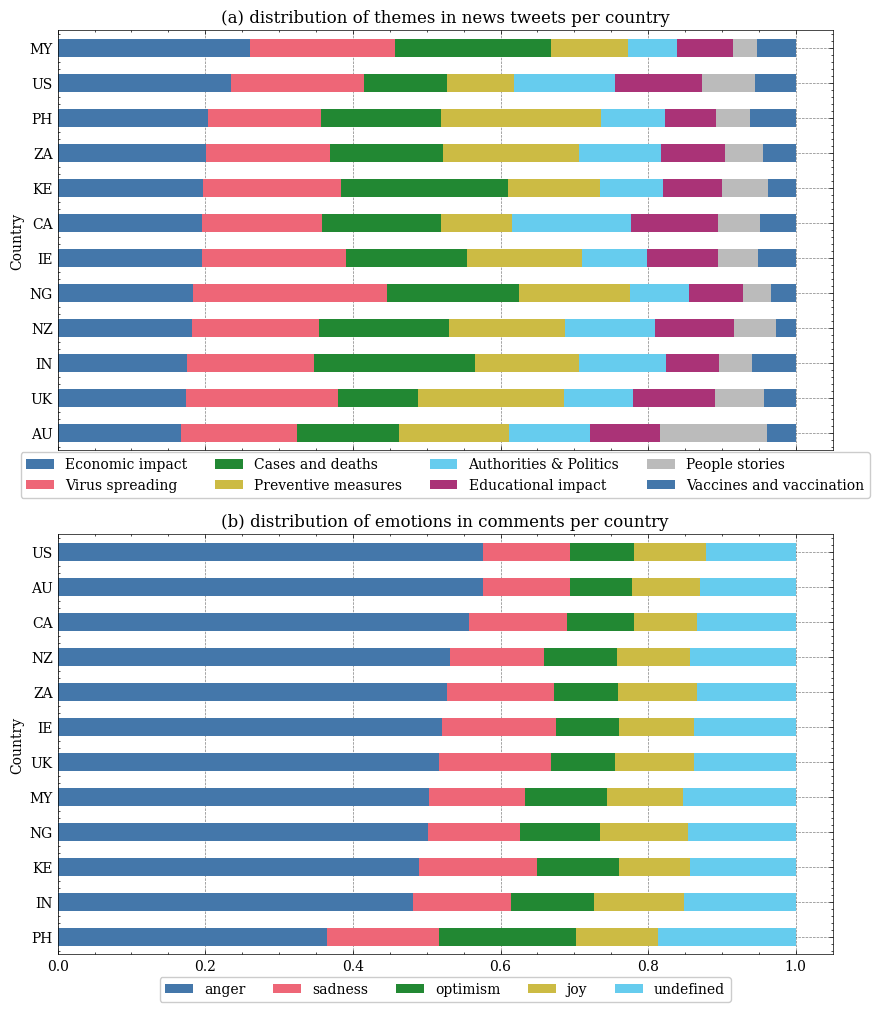

In [19]:
# plot a Stacked Bar Chart using matplotlib
with plt.style.context(['science', 'bright', 'no-latex', 'grid']):
    
    fig, axs = plt.subplots(2,1,figsize=(10, 12), sharex=True)

    fig2_th.plot(
        ax=axs[0],
        title="(a) distribution of themes in news tweets per country",
        xlabel = 'Country',
        x = 'country',
        kind = 'barh',
        stacked = True,
        mark_right = True).legend(loc='lower center', bbox_to_anchor=(0.5, -0.13),ncol=4)

    fig2_em.plot(
        ax=axs[1],
        title="(b) distribution of emotions in comments per country",
        xlabel = 'Country',
        x = 'country',
        kind = 'barh',
        stacked = True,
        mark_right = True).legend(loc='lower center', bbox_to_anchor=(0.5, -0.13), ncol=5)

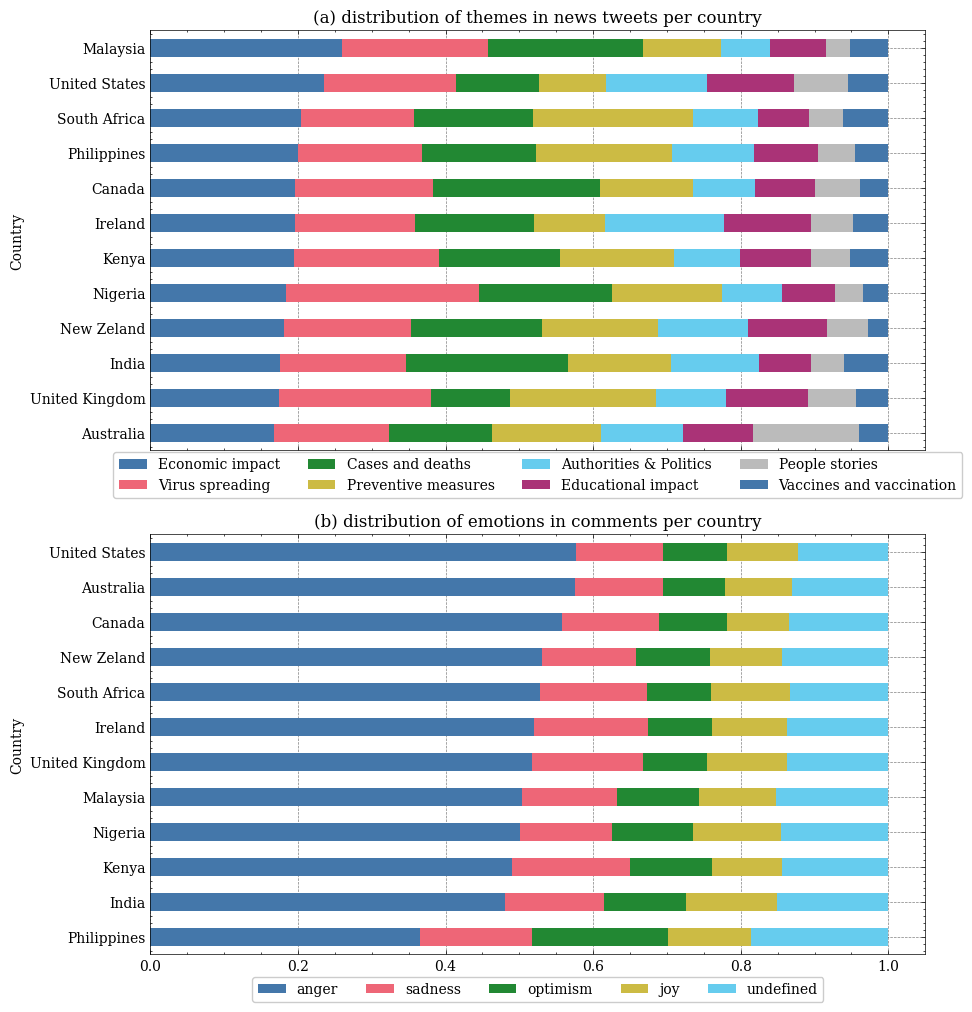

In [32]:
# plot a Stacked Bar Chart using matplotlib
with plt.style.context(['science', 'bright', 'no-latex', 'grid']):
    
    fig, axs = plt.subplots(2,1,figsize=(10, 12), sharex=True)

    fig2_th['country'] = fig2_th.country.replace(cd)
    fig2_th.plot(
        ax=axs[0],
        title="(a) distribution of themes in news tweets per country",
        xlabel = 'Country',
        x = 'country',
        kind = 'barh',
        stacked = True,
        mark_right = True).legend(loc='lower center', bbox_to_anchor=(0.5, -0.13),ncol=4)
    axs[0].set_yticklabels([
        'Australia', 'United Kingdom', 'India', 'New Zeland', 'Nigeria', 'Kenya', 'Ireland',
        'Canada', 'Philippines', 'South Africa', 'United States', 'Malaysia'])

    fig2_em['country'] = fig2_em.country.replace(cd)
    fig2_em.plot(
        ax=axs[1],
        title="(b) distribution of emotions in comments per country",
        xlabel = 'Country',
        x = 'country',
        kind = 'barh',
        stacked = True,
        mark_right = True).legend(loc='lower center', bbox_to_anchor=(0.5, -0.13), ncol=5)
    axs[1].set_yticklabels([
        'Philippines', 'India', 'Kenya', 'Nigeria', 'Malaysia', 'United Kingdom', 'Ireland',
        'South Africa', 'New Zeland', 'Canada', 'Australia', 'United States'])

### Fig 3
- Each month's lift represents how that continent performed in relation to global mean of that emotion in that specific month.

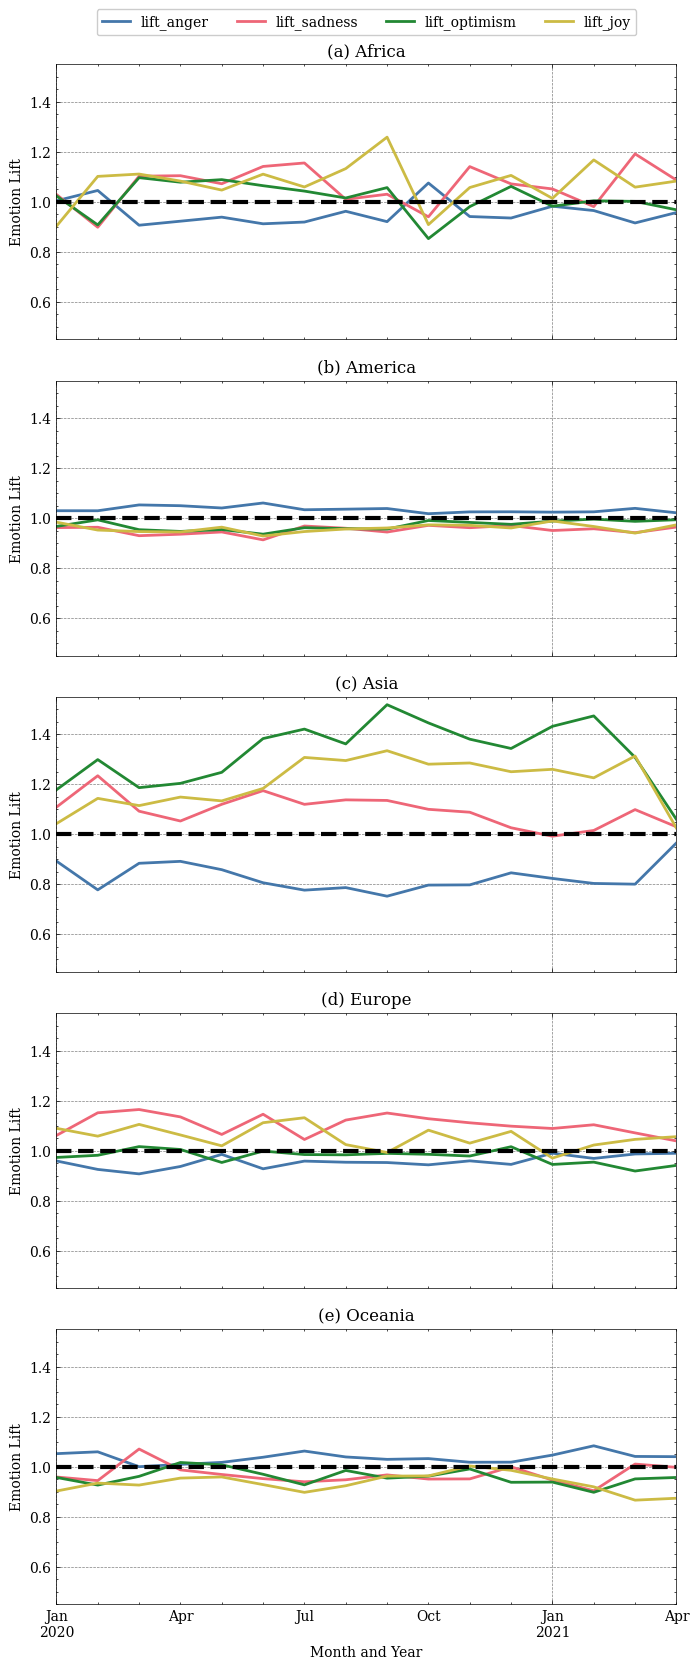

In [13]:
fig3_gn = comments.groupby('dsm')[emotions].mean().reset_index()
fig3_lf = comments.groupby(['continent', 'dsm']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
fig3_lf = fig3_lf.merge(fig3_gn, on='dsm', suffixes=('_continent', '_general'))

for col in emotions:
    fig3_lf['lift_' + col] = fig3_lf[col + '_continent'] / fig3_lf[col + '_general']

with plt.style.context(['science', 'bright', 'no-latex', 'grid']):
    gen_ylim = (.45,1.55)
    fig, axs = plt.subplots(5,1,figsize=(8, 20), sharex='all')
    plt.subplots_adjust(hspace=0.15)
    fig3_lf[fig3_lf.continent=='Africa'].set_index('dsm')[['lift_anger', 'lift_sadness', 'lift_optimism', 'lift_joy']].plot(ax=axs[0], ylim=gen_ylim, title='(a) Africa', linewidth=2, ylabel = "Emotion Lift").legend(loc='lower center', bbox_to_anchor=(0.5, 1.08),ncol=4)
    axs[0].axhline(1, xmin=0, xmax=1, color='k', linestyle='--', lw=3)
    fig3_lf[fig3_lf.continent=='America'].set_index('dsm')[['lift_anger', 'lift_sadness', 'lift_optimism', 'lift_joy']].plot(ax=axs[1], ylim=gen_ylim, title='(b) America', legend=False, linewidth=2, ylabel = "Emotion Lift")
    axs[1].axhline(1, xmin=0, xmax=1, color='k', linestyle='--', lw=3)
    fig3_lf[fig3_lf.continent=='Asia'].set_index('dsm')[['lift_anger', 'lift_sadness', 'lift_optimism', 'lift_joy']].plot(ax=axs[2], ylim=gen_ylim, title='(c) Asia', legend=False, linewidth=2, ylabel = "Emotion Lift")
    axs[2].axhline(1, xmin=0, xmax=1, color='k', linestyle='--', lw=3)
    fig3_lf[fig3_lf.continent=='Europe'].set_index('dsm')[['lift_anger', 'lift_sadness', 'lift_optimism', 'lift_joy']].plot(ax=axs[3], ylim=gen_ylim, title='(d) Europe', legend=False, linewidth=2, ylabel = "Emotion Lift")
    axs[3].axhline(1, xmin=0, xmax=1, color='k', linestyle='--', lw=3)
    fig3_lf[fig3_lf.continent=='Oceania'].set_index('dsm')[['lift_anger', 'lift_sadness', 'lift_optimism', 'lift_joy']].plot(ax=axs[4], ylim=gen_ylim, title='(e) Oceania', legend=False, linewidth=2, ylabel = "Emotion Lift", xlabel='Month and Year')
    axs[4].axhline(1, xmin=0, xmax=1, color='k', linestyle='--', lw=3)

### Fig 4

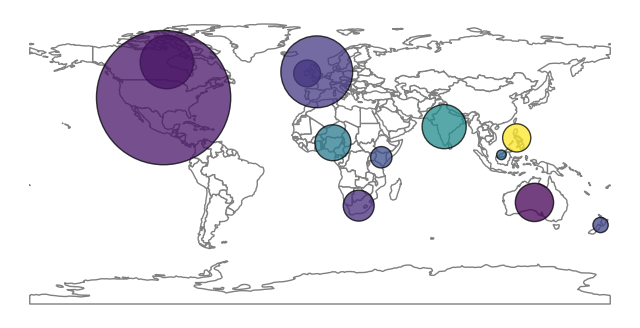

In [14]:
comments['positive'] = comments.joy + comments.optimism
comments['negative'] = comments.anger + comments.sadness
fig4_cn = comments.groupby(['country']) \
       .agg({'positive':'mean', 'negative':'mean', 'tweetId':'count'}) \
       .reset_index()
fig4_cn['mean_emotion'] = (fig4_cn.positive - fig4_cn.negative)
fig4_lc = pd.read_csv('./../data/external/countries_codes_and_coordinates.txt')
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

for col in fig4_lc.columns:
    fig4_lc[col] = fig4_lc[col].apply(lambda x: x.replace('"', ''))
fig4_lc = fig4_lc[['Alpha-2 code', 'Latitude (average)', 'Longitude (average)']]
fig4_lc.columns = ['country', 'lat', 'lng']
fig4_lc['lat'] = fig4_lc.lat.astype(float)
fig4_lc['lng'] = fig4_lc.lng.astype(float)

fig4_lc = geopandas.GeoDataFrame(
    fig4_lc, geometry=geopandas.points_from_xy(fig4_lc.lng, fig4_lc.lat))
fig4_lc['country'] = fig4_lc.country.apply(lambda x: x.replace(' ',''))
fig4_lc.loc[fig4_lc.country=='GB', 'country'] = 'UK'
fig4_lc = fig4_lc.merge(fig4_cn)
fig4_lc['tweetId'] = fig4_lc.tweetId / 1000

tweet_count = fig4_lc.tweetId.values
mean_emotion = fig4_lc.mean_emotion.values

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_aspect('equal')
base = world.plot(ax=ax, color='white', edgecolor='gray')
fig4_lc.plot(ax=ax, marker='o', c=mean_emotion, markersize="tweetId", alpha=0.75, edgecolors="black", linewidth=1, categorical=False)

ax.axis("off")
plt.axis('equal')
plt.show()

In [15]:
# from mpl_toolkits.basemap import Basemap
# import matplotlib.pyplot as plt
# # setup Lambert Conformal basemap.
# m = Basemap(width=12000000,height=9000000,projection='lcc',
#             resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# # draw coastlines.
# m.drawcoastlines()
# # draw a boundary around the map, fill the background.
# # this background will end up being the ocean color, since
# # the continents will be drawn on top.
# m.drawmapboundary(fill_color='aqua')
# # fill continents, set lake color same as ocean color.
# m.fillcontinents(color='coral',lake_color='aqua')
# plt.show()

### Fig 5

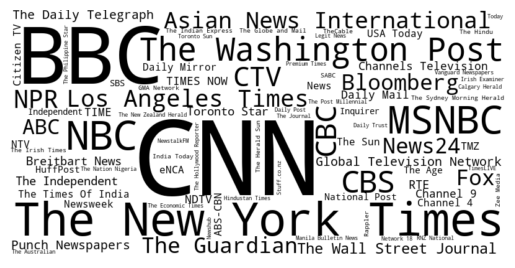

In [16]:
#n = news_tweets.groupby('userId').replyCount.count().reset_index().merge(news_accounts[['userId', 'media_outlet']])[['media_outlet', 'replyCount']]
n = comments.groupby('news_id').tweetId.count().reset_index().merge(news_accounts[['userId', 'media_outlet']], left_on='news_id', right_on='userId')[['media_outlet', 'tweetId']].groupby('media_outlet').tweetId.sum().reset_index()
n = n.replace('ABC (American Broadcasting Company)', 'ABC')
n = n.replace('ABC (Australian Broadcasting Corporation)', 'ABC')
d = {}
for index, row in n.iterrows():
    d[row.media_outlet] = int(row.tweetId)
wordcloud = WordCloud(
    relative_scaling=.5, background_color='white', color_func=lambda *args, **kwargs: (0,0,0), random_state=13, min_font_size=8, width=800, height=400
).generate_from_frequencies(d)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Fig 6

In [17]:
topics = [2,5,8,11,14,17,20,23,26,29,32,35,38]
coherence = [0.2036,0.3581,0.4137,0.4588,0.4903,0.4944,0.5093,0.5104,0.5184,0.5229,0.5419,0.5391,0.5432]

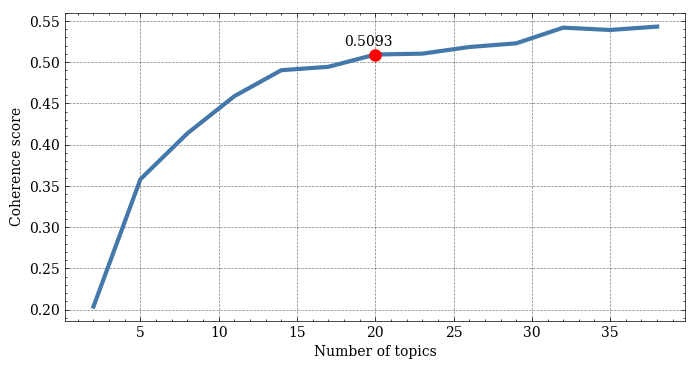

In [18]:
with plt.style.context(['science', 'bright', 'no-latex', 'grid']):
    fig, axs = plt.subplots(figsize=(8, 4))
    axs.set_ylabel('Coherence score')
    axs.set_xlabel('Number of topics')    
    axs.annotate('0.5093', xy=(18, .52))
    
    plt.plot(topics, coherence, linewidth=3, )
    plt.plot(20, 0.5093, 'ro', markersize=8, )